# KNN Implementation on scaled reduced dataset with PCA

In [5]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
df_scaled = pd.read_csv('../..Data/dataset_preprocessed.csv')

In [7]:
columns = df_scaled.columns

In [8]:
df_pca_train = pd.read_csv('../../DimensionalityReductionData/X_train_PCA.csv', names=columns)

In [9]:
df_pca_test = pd.read_csv('../../DimensionalityReductionData/X_test_PCA.csv', names = columns)

In [10]:
labels = df_scaled['averageRating']
_, _, y_train, y_test = train_test_split(df_scaled.drop(columns=['averageRating']), labels, test_size=0.2, random_state=42)

df_pca_train['averageRating'] = y_train.reset_index(drop=True)
df_pca_test['averageRating'] = y_test.reset_index(drop=True)

In [11]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }

    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()

    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()

    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])

    return df_metrics

In [14]:
df_pca_train = df_pca_train.clip(lower=0)
df_pca_test = df_pca_test.clip(lower=0)

df_pca_train.fillna(0.0, inplace=True)
df_pca_test.fillna(0.0, inplace=True)

model = KNeighborsClassifier()
model.fit(df_pca_train[1:], y_train)

predictions = model.predict(df_pca_test)
print("Accuracy:", accuracy_score(y_test, predictions, ))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.5379746835443038
F1 score: [0.54894309 0.52645954]


In [16]:
param_grid = {
    'n_neighbors': [3, 7, 15],
    'p': [1, 2, 3, 4.3],
    'n_jobs': [-1, 1]
}

model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(df_pca_train[1:], y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The parameters with the highest score:  {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}


In [17]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                         params  mean_test_score
8     {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}         0.590056
20     {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}         0.590056
21     {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}         0.585308
9     {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}         0.585308
10    {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}         0.584308
22     {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}         0.584308
11  {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}         0.582475
23   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}         0.582475
4      {'n_jobs': -1, 'n_neighbors': 7, 'p': 1}         0.577893
16      {'n_jobs': 1, 'n_neighbors': 7, 'p': 1}         0.577893


Metrics for KNN-PCA-GS-CV1:
Accuracy: 0.5463
Weighted F1: 0.5457
Weighted Precision: 0.5465
Weighted Recall: 0.5463
Macro-Averaged Precision: 0.5465
Macro-Averaged Recall: 0.5462
F1: [0.56318153 0.52806653]
Precision: [0.54432734 0.54859611]
classification report
              precision    recall  f1-score   support

     Class 0       0.54      0.58      0.56      1505
     Class 1       0.55      0.51      0.53      1497

    accuracy                           0.55      3002
   macro avg       0.55      0.55      0.55      3002
weighted avg       0.55      0.55      0.55      3002

Confusion Matrix


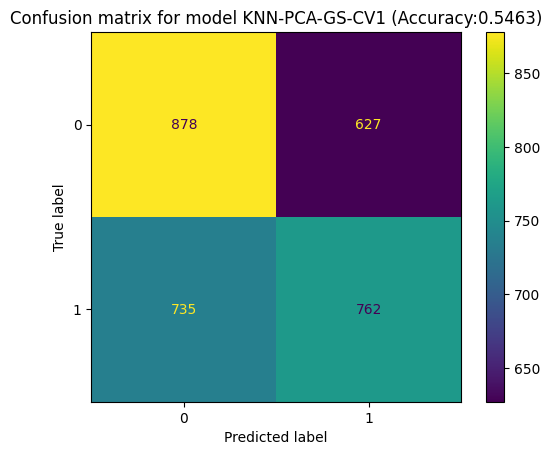

In [19]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(df_pca_test)
_ = calculate_metrics('KNN-PCA-GS-CV1', y_test, predictions)

In [22]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = KNeighborsClassifier(**params)
  model.fit(df_pca_train[1:], y_train)

  predictions = model.predict(df_pca_test)
  predictions = predictions[1:]
  chosen_accuracy = accuracy_score(y_test[1:], predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))

Parameters from place:  0   {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.5464845051649451
Parameters from place:  1   {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.5464845051649451
Parameters from place:  2   {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.538487170943019
Parameters from place:  3   {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.538487170943019
Parameters from place:  4   {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.5388203932022659
Parameters from place:  5   {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.5388203932022659
Parameters from place:  6   {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.5391536154615129
Parameters from place:  7   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.5391536154615129
Parameters from place:  8   {'n_jo

In [23]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [24]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.5464845051649451
{'n_jobs': -1, 'n_neighbors': 15, 'p': 1}


In [27]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = KNeighborsClassifier(**params)
  model.fit(df_pca_train[1:], y_train)

  predictions = model.predict(df_pca_train)

  chosen_accuracy = accuracy_score(y_train, predictions[1:])
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6635288237254249
Parameters from place:  1   {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6635288237254249
Parameters from place:  2   {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.6634455181606131
Parameters from place:  3   {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.6634455181606131
Parameters from place:  4   {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6609463512162612
Parameters from place:  5   {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6609463512162612
Parameters from place:  6   {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.657947350883039
Parameters from place:  7   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.657947350883039
Parameters from place:  8   {'n_jo